In [178]:
import math
from datetime import timedelta, datetime

import pandas as pd
import matplotlib.pyplot as plt

In [179]:
df = pd.read_csv('data/mouse_tracking_data_dump_ilia.csv')
df["time"] = pd.to_datetime(df['time'] * 10**9)

l = len(df)
df = df.drop_duplicates(['time', 'event_type'])
print(f'dropped {l - len(df)} duplicates')
df

dropped 9095 duplicates


,event_type,button,x,y,delta,time
0,move,NaN,854.0,162.0,NaN,2023-09-16 10:04:27.453110016
1,move,NaN,856.0,164.0,NaN,2023-09-16 10:04:27.460122880
2,move,NaN,863.0,167.0,NaN,2023-09-16 10:04:27.468109056
3,move,NaN,874.0,172.0,NaN,2023-09-16 10:04:27.475104512
4,move,NaN,895.0,185.0,NaN,2023-09-16 10:04:27.482106368
...,...,...,...,...,...,...
326020,move,NaN,1199.0,635.0,NaN,2023-09-16 16:49:13.447462656
326021,move,NaN,1198.0,635.0,NaN,2023-09-16 16:49:13.454763776
326022,move,NaN,1197.0,635.0,NaN,2023-09-16 16:49:13.469046272
326023,down,left,NaN,NaN,NaN,2023-09-16 16:49:13.632142336


In [180]:
_df: pd.DataFrame = df.copy()

rows = _df.to_dict('records')
rows

[{'event_type': 'move',
  'button': nan,
  'x': 854.0,
  'y': 162.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 10:04:27.453110016')},
 {'event_type': 'move',
  'button': nan,
  'x': 856.0,
  'y': 164.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 10:04:27.460122880')},
 {'event_type': 'move',
  'button': nan,
  'x': 863.0,
  'y': 167.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 10:04:27.468109056')},
 {'event_type': 'move',
  'button': nan,
  'x': 874.0,
  'y': 172.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 10:04:27.475104512')},
 {'event_type': 'move',
  'button': nan,
  'x': 895.0,
  'y': 185.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 10:04:27.482106368')},
 {'event_type': 'move',
  'button': nan,
  'x': 938.0,
  'y': 208.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 10:04:27.490106368')},
 {'event_type': 'move',
  'button': nan,
  'x': 975.0,
  'y': 232.0,
  'delta': nan,
  'time': Timestamp('2023-09-16 10:04:27.498110976')},
 {'event_type': 'mov

In [181]:
print(f"{len(rows)} rows")

trajectory_i = -1
_rows = rows.copy()
filtered_trajectories = []
trajectory_begin = None
for i, row in enumerate(rows):
    _rows[i]['trajectory'] = trajectory_i
    row['time'] = row['time'].to_pydatetime()
    
    
    if not trajectory_begin:  # first record of trajectory
        trajectory_begin = row['time']
    if row['event_type'] != 'move':  # click / scroll
        if timedelta(seconds=1) < row['time'] - trajectory_begin < timedelta(seconds=10):
           filtered_trajectories.append(trajectory_i)
        trajectory_i += 1
        trajectory_begin = None
       
print(f"found {len(filtered_trajectories)} good trajectories")       

rows = _rows 
_rows = []
trajectory_i = 0
prev = -1
for row in rows:
    if row['trajectory'] in filtered_trajectories:
        if prev != row['trajectory']:
            prev = row['trajectory']
            trajectory_i += 1
            
        row['trajectory'] = trajectory_i
        _rows.append(row)

rows = _rows
print(f"{len(rows)} rows")

316930 rows


C:\Users\iliaz\AppData\Local\Temp\ipykernel_20756\3255062157.py:9: UserWarning: Discarding nonzero nanoseconds in conversion.
  row['time'] = row['time'].to_pydatetime()


found 1391 good trajectories
179966 rows


In [182]:
trajectory_i = 0
i = 0

trajectories = []

while i < len(rows):
    i0 = i
    i += 1  # to enable computations on i-1
    avg_speed = 0
    prev_time = rows[i0]['time']
    points_x = [rows[i0]['x']]
    points_y = [rows[i0]['y']]
    
    while i < len(rows) and rows[i]['event_type'] == 'move':  # rows[i]['trajectory'] == trajectory_i and
        avg_speed += math.sqrt((rows[i]['x'] - rows[i-1]['x']) ** 2 + (rows[i]['y'] - rows[i-1]['y']) ** 2) \
                     / (rows[i]['time'] - rows[i-1]['time']).microseconds * 10 ** 6
        
        timepoint = prev_time + timedelta(milliseconds=300)
        while rows[i]['time'] >= timepoint:
            coef = (timepoint - rows[i-1]['time']) / (rows[i]['time'] - rows[i-1]['time'])
            points_x.append(rows[i-1]['x'] + coef * (rows[i]['x'] - rows[i-1]['x']))
            points_y.append(rows[i-1]['y'] + coef * (rows[i]['y'] - rows[i-1]['y']))
            prev_time = timepoint
            timepoint = prev_time + timedelta(milliseconds=300)
            
        i += 1
        
    eqdir = []
    for j in range(1, len(points_x)-1):
        eqdir.append(int((points_x[j] - points_x[j-1] > 0) == (points_x[j+1] - points_x[j] > 0) \
                     and (points_y[j] - points_y[j-1] > 0) == (points_y[j+1] - points_y[j] > 0)))
    
    if eqdir:  # otherwise e.g. the movement itself was short, then a small pause and a click
        accuracy = sum(eqdir) / len(eqdir)
        
        n_events = i - i0
        avg_speed = avg_speed / n_events
        trajectories.append({'id': trajectory_i,
                             'start': rows[i0]['time'],
                             'end': rows[i]['time'],
                             'speed': avg_speed,
                             'accuracy': accuracy})
    
    i += 1  # account for click/scroll event in the end of trajectory
    trajectory_i += 1
    

In [183]:
df = pd.DataFrame(trajectories)
df

,id,start,end,speed,accuracy
0,0,2023-09-16 10:04:27.453110,2023-09-16 10:04:28.795378,1710.624302,0.333333
1,1,2023-09-16 10:04:29.028103,2023-09-16 10:04:31.781125,1194.989438,0.142857
2,2,2023-09-16 10:04:32.297522,2023-09-16 10:04:34.225166,393.476454,0.600000
3,3,2023-09-16 10:04:34.915223,2023-09-16 10:04:37.382692,893.558744,0.166667
4,4,2023-09-16 10:04:38.358038,2023-09-16 10:04:42.520553,936.190945,0.833333
...,...,...,...,...,...
1341,1386,2023-09-16 16:48:22.844147,2023-09-16 16:48:24.547745,1211.831980,0.250000
1342,1387,2023-09-16 16:48:25.475428,2023-09-16 16:48:26.549511,1537.818823,0.000000
1343,1388,2023-09-16 16:48:27.561296,2023-09-16 16:48:30.514588,276.978701,1.000000
1344,1389,2023-09-16 16:48:31.811973,2023-09-16 16:48:33.832612,1096.597714,0.600000


In [184]:
time_s = df#.set_index('time')#.iloc[:1000, :].pivot(index='time', columns='x').resample('T').count()
time_s = time_s.groupby(pd.Grouper(key='start', freq='3Min')).mean()[['speed', 'accuracy']]
time_s

C:\Users\iliaz\AppData\Local\Temp\ipykernel_20756\753659786.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_s = time_s.groupby(pd.Grouper(key='start', freq='3Min')).mean()[['speed', 'accuracy']]


,speed,accuracy
start,,
2023-09-16 10:03:00,1128.302546,0.496220
2023-09-16 10:06:00,978.099004,0.473470
2023-09-16 10:09:00,1383.824013,0.655241
2023-09-16 10:12:00,1371.526047,0.612861
2023-09-16 10:15:00,983.555005,0.536867
...,...,...
2023-09-16 16:36:00,NaN,NaN
2023-09-16 16:39:00,NaN,NaN
2023-09-16 16:42:00,994.806404,0.497549


<Axes: xlabel='start'>

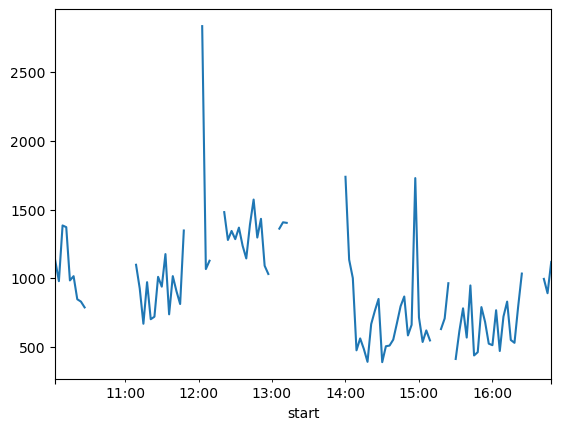

In [185]:
time_s['speed'].plot()

<Axes: xlabel='start'>

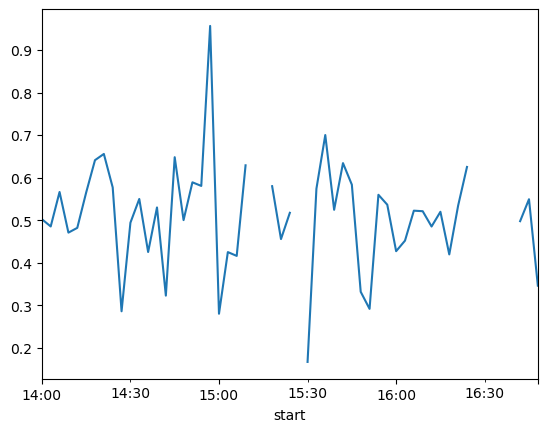

In [186]:
time_s['accuracy'][datetime.fromisoformat('2023-09-16 14:00:00'):].plot()

<Axes: xlabel='start'>

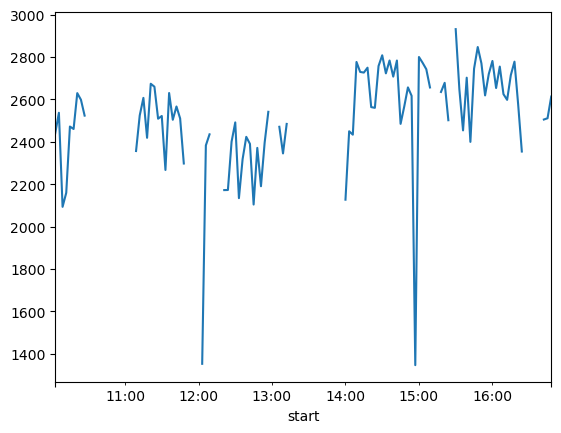

In [188]:
(-time_s['accuracy']*time_s['speed'] + 3000).plot()
